# A/B test, traffic shift, and autoscale across 2 model variants

In [1]:
!pip install --disable-pip-version-check -q sagemaker==2.35.0
!pip install --disable-pip-version-check -q jsonlines==3.1.0

# _Ignore WARNING messages ^^ above ^^_

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'


In [3]:
import boto3
import sagemaker
import pandas as pd
import botocore

config = botocore.config.Config(user_agent_extra='dlai-pds/c3/w2')

# Amazon SageMaker Python APIs
sm = boto3.client(service_name='sagemaker', 
                  config=config)

sm_runtime = boto3.client('sagemaker-runtime',
                          config=config)

# Amazon CloudWatch Python APIs
cw = boto3.client(service_name='cloudwatch', 
                  config=config)

# Amazon SageMaker Autoscaling Python APIs
autoscale = boto3.client(service_name="application-autoscaling", 
                         config=config)

sess = sagemaker.Session(sagemaker_client=sm,
                         sagemaker_runtime_client=sm_runtime)

bucket = sess.default_bucket()
role = sagemaker.get_execution_role()
region = sess.boto_region_name

# 1. Create an endpoint with multiple variants

Each model variant was trained to predict the sentiment of customer reviews into positive (1), neutral (0), or negative (-1).  

The models are saved as .tar.gz files in the following S3 locations.

In [4]:
model_a_s3_uri = 's3://dsoaws/workshop/models/ab/variant_a/model.tar.gz'
model_b_s3_uri = 's3://dsoaws/workshop/models/ab/variant_b/model.tar.gz'


### 1.1 Specify the Docker image and instance type 
This example uses a Docker image which has PyTorch and TorchServe pre-installed. 

We use the `ml.m5.large` instance type which has 2 CPUs and 8 GB memory because it is a good balance of price and performance.  

There are many instance types available [here](https://aws.amazon.com/sagemaker/pricing/).

<img src="img/endpoint-workflow-1-image.png" width="60%" align="center">



In [5]:
inference_instance_type = 'ml.m5.large'

inference_image_uri = sagemaker.image_uris.retrieve(
    framework='pytorch', 
    version='1.6.0',
    instance_type=inference_instance_type,
    region=region,
    py_version='py3',
    image_scope='inference'
)
print('Docker image: {}'.format(inference_image_uri))


Docker image: 763104351884.dkr.ecr.us-east-1.amazonaws.com/pytorch-inference:1.6.0-cpu-py3


### 1.2 Register each model.tar.gz variant with SageMaker

Create an Amazon SageMaker Model based on the `model_a_s3_uri` data.

The `PrimaryContainer` includes the S3 location of each model.tar.gz (`ModelDataUrl` key), Docker image to use (`Image` key), number of instances (`initial_instance_count` key), and traffic-split percentage (`initial_weight` key) used to serve the model.

<img src="img/endpoint-workflow-2-models.png" width="60%" align="center">

In [6]:
import time
from pprint import pprint

timestamp = int(time.time())

model_name_a = '{}-{}'.format('a', timestamp)
model_name_b = '{}-{}'.format('b', timestamp)


In [7]:
from sagemaker.session import production_variant

model_a = sm.create_model(
    ModelName=model_name_a,
    ExecutionRoleArn=role,
    PrimaryContainer={
        'ModelDataUrl': model_a_s3_uri, 
        'Image': inference_image_uri 
    }
)
pprint(model_a)

{'ModelArn': 'arn:aws:sagemaker:us-east-1:144249581974:model/a-1668103408',
 'ResponseMetadata': {'HTTPHeaders': {'content-length': '74',
                                      'content-type': 'application/x-amz-json-1.1',
                                      'date': 'Thu, 10 Nov 2022 18:03:29 GMT',
                                      'x-amzn-requestid': 'c9c1338d-f2e5-4e23-a5b4-5a2ca96f21cd'},
                      'HTTPStatusCode': 200,
                      'RequestId': 'c9c1338d-f2e5-4e23-a5b4-5a2ca96f21cd',
                      'RetryAttempts': 0}}


In [8]:
from sagemaker.session import production_variant

model_b = sm.create_model(
    ModelName=model_name_b, 
    ExecutionRoleArn=role, 
    PrimaryContainer={
        'ModelDataUrl': model_b_s3_uri, 
        'Image': inference_image_uri
    }
)
pprint(model_b)

{'ModelArn': 'arn:aws:sagemaker:us-east-1:144249581974:model/b-1668103408',
 'ResponseMetadata': {'HTTPHeaders': {'content-length': '74',
                                      'content-type': 'application/x-amz-json-1.1',
                                      'date': 'Thu, 10 Nov 2022 18:03:30 GMT',
                                      'x-amzn-requestid': '6ac09edc-00d8-436c-bfed-ec528baad381'},
                      'HTTPStatusCode': 200,
                      'RequestId': '6ac09edc-00d8-436c-bfed-ec528baad381',
                      'RetryAttempts': 2}}


### 1.3. Create a `production_variant` for each model

The production variants will be compared directly in production.

<img src="img/endpoint-workflow-3-variants.png" width="60%" align="center">

In [9]:
variantA = production_variant(
    model_name=model_name_a, 
    instance_type=inference_instance_type,
    initial_weight=50,
    initial_instance_count=1,
    variant_name='VariantA',
)
print(variantA)

variantB = production_variant(
    model_name=model_name_b,
    instance_type=inference_instance_type,
    initial_weight=50, 
    initial_instance_count=1,
    variant_name='VariantB'
)
print(variantB)

{'ModelName': 'a-1668103408', 'InstanceType': 'ml.m5.large', 'InitialInstanceCount': 1, 'VariantName': 'VariantA', 'InitialVariantWeight': 50}
{'ModelName': 'b-1668103408', 'InstanceType': 'ml.m5.large', 'InitialInstanceCount': 1, 'VariantName': 'VariantB', 'InitialVariantWeight': 50}


### 1.4. Create the endpoint configuration

Create the endpoint configuration by specifying the two production variants that you just configured.

In this example, we will also enable [data capture](https://docs.aws.amazon.com/sagemaker/latest/dg/model-monitor-data-capture-endpoint.html) to log the prediction requests and responses from our models.

<img src="img/endpoint-workflow-4-configuration.png" width="60%" align="center">


In [10]:
endpoint_config_name = '{}-{}'.format('ab', timestamp)

# Sampling percentage. Choose an integer value between 0 and 100
initial_sampling_percentage = 20 

# The S3 URI containing the captured data
data_capture_s3_uri = 's3://{}/endpoint_data_capture/'.format(bucket)

endpoint_config = sm.create_endpoint_config(
    EndpointConfigName=endpoint_config_name, 
    ProductionVariants=[variantA, variantB],
    DataCaptureConfig= {
        'EnableCapture': True, 
        'InitialSamplingPercentage' : initial_sampling_percentage,
        'DestinationS3Uri': data_capture_s3_uri,
        'CaptureOptions': [
            {'CaptureMode': 'Input'}, # capture requests
            {'CaptureMode': 'Output'} # capture responses
        ] 
    }
)
pprint(endpoint_config)
    

{'EndpointConfigArn': 'arn:aws:sagemaker:us-east-1:144249581974:endpoint-config/ab-1668103408',
 'ResponseMetadata': {'HTTPHeaders': {'content-length': '94',
                                      'content-type': 'application/x-amz-json-1.1',
                                      'date': 'Thu, 10 Nov 2022 18:03:30 GMT',
                                      'x-amzn-requestid': '56409813-0c87-4810-b7b2-9c5fa11d8db0'},
                      'HTTPStatusCode': 200,
                      'RequestId': '56409813-0c87-4810-b7b2-9c5fa11d8db0',
                      'RetryAttempts': 0}}


### 1.5 Create the SageMaker REST endpoint.

<img src="img/endpoint-workflow-5-endpoint.png" width="60%" align="center">


In [11]:
model_ab_endpoint_name = '{}-{}'.format('ab', timestamp)
print('Endpoint name: {}'.format(model_ab_endpoint_name))

endpoint_response = sm.create_endpoint(
    EndpointName=model_ab_endpoint_name,
    EndpointConfigName=endpoint_config_name
)
print('Creating endpoint {}'.format(model_ab_endpoint_name))
pprint(endpoint_response)


Endpoint name: ab-1668103408
Creating endpoint ab-1668103408
{'EndpointArn': 'arn:aws:sagemaker:us-east-1:144249581974:endpoint/ab-1668103408',
 'ResponseMetadata': {'HTTPHeaders': {'content-length': '81',
                                      'content-type': 'application/x-amz-json-1.1',
                                      'date': 'Thu, 10 Nov 2022 18:03:31 GMT',
                                      'x-amzn-requestid': '3be93e62-5bf5-48b1-a13c-c4f4db386378'},
                      'HTTPStatusCode': 200,
                      'RequestId': '3be93e62-5bf5-48b1-a13c-c4f4db386378',
                      'RetryAttempts': 0}}


### 1.6 Review the created endpoint in the AWS console.

In [12]:
from IPython.core.display import display, HTML

display(HTML('<b>Review <a target="blank" href="https://console.aws.amazon.com/sagemaker/home?region={}#/endpoints/{}">SageMaker REST endpoint</a></b>'.format(region, model_ab_endpoint_name)))

### 1.7 Review `inference.py`

Click here to review the code:  [inference.py](src/inference.py).

### 1.8 Wait for the endpoint to deploy (5-10 minutes).

In [13]:
%%time

waiter = sm.get_waiter('endpoint_in_service')
waiter.wait(EndpointName=model_ab_endpoint_name)

CPU times: user 256 ms, sys: 9.69 ms, total: 266 ms
Wall time: 9min 32s


# _Wait until the ^^ endpoint ^^ is deployed_

# 2. Test the model predictions

### 2.1. Test the model on a few sample product reviews


Create an Amazon SageMaker `Predictor` class to access the deployed REST endpoint.

The Predictor class uses using the `JSONLinesSerializer()` to converting json data to raw tensors for the request.  

The Predictor class uses and `JSONLinesDeserializer()` to convert raw tensors back to json data for the response.  

More information about the serializers can be found [here](https://sagemaker.readthedocs.io/en/stable/api/inference/serializers.html).


In [14]:
from sagemaker.predictor import Predictor
from sagemaker.serializers import JSONLinesSerializer
from sagemaker.deserializers import JSONLinesDeserializer

inputs = [
    {"features": ["I love this product!"]},
    {"features": ["OK, but not great."]},
    {"features": ["This is not the right product."]},
]

predictor = Predictor(
    endpoint_name=model_ab_endpoint_name, 
    serializer=JSONLinesSerializer(), 
    deserializer=JSONLinesDeserializer(),
    sagemaker_session=sess
)

predicted_classes = predictor.predict(inputs)

for idx, predicted_class in enumerate(predicted_classes):
    print("Predicted sentiment [{}] for review {} with probability [{}]".format(predicted_class['predicted_label'], inputs[idx]['features'], predicted_class['probability']))


Predicted sentiment [1] for review ['I love this product!'] with probability [0.9605445861816406]
Predicted sentiment [0] for review ['OK, but not great.'] with probability [0.5798221230506897]
Predicted sentiment [-1] for review ['This is not the right product.'] with probability [0.7667604684829712]


### 2.2. Prepare to review model system metrics from Amazon CloudWatch

Let's analyze some of the model system metrics tracked by Amazon CloudWatch including the following:
* CPU Utilization
* Latency
* Number of Invocations. 

The full list of metrics can be found [here](https://docs.aws.amazon.com/sagemaker/latest/dg/monitoring-cloudwatch.html).

But before that, let's create a function that will help to extract the results from CloudWatch and plot them.

In [15]:
def plot_endpoint_metrics_for_variants(endpoint_name, 
                                       namespace_name, 
                                       metric_name, 
                                       variant_names, 
                                       start_time, 
                                       end_time):
    
    try:
        joint_variant_metrics = None

        for variant_name in variant_names:
            metrics = cw.get_metric_statistics( # extracts the results in a dictionary format
                Namespace=namespace_name, # the namespace of the metric, e.g. "AWS/SageMaker"
                MetricName=metric_name, # the name of the metric, e.g. "CPUUtilization"
                StartTime=start_time, # the time stamp that determines the first data point to return
                EndTime=end_time, # the time stamp that determines the last data point to return
                Period=60, # the granularity, in seconds, of the returned data points
                Statistics=["Sum"], # the metric statistics
                Dimensions=[ # dimensions, as CloudWatch treats each unique combination of dimensions as a separate metric
                    {"Name": "EndpointName", "Value": endpoint_name}, 
                    {"Name": "VariantName", "Value": variant_name}
                ],
            )
            
            if metrics["Datapoints"]: # access the results from the distionary using the key "Datapoints"
                df_metrics = pd.DataFrame(metrics["Datapoints"]) \
                    .sort_values("Timestamp") \
                    .set_index("Timestamp") \
                    .drop("Unit", axis=1) \
                    .rename(columns={"Sum": variant_name}) # rename the column with the metric results as a variant_name
                
                if joint_variant_metrics is None:
                    joint_variant_metrics = df_metrics
                else:
                    joint_variant_metrics = joint_variant_metrics.join(df_metrics, how="outer")
        
        joint_variant_metrics.plot(title=metric_name)
    except:
        pass
    

# Establish wide enough time bounds to show all the charts using the same timeframe:
from datetime import datetime, timedelta

start_time = datetime.now() - timedelta(minutes=30)
end_time = datetime.now() + timedelta(minutes=30)

print('Start Time: {}'.format(start_time))
print('End Time: {}'.format(end_time))

Start Time: 2022-11-10 17:43:05.382730
End Time: 2022-11-10 18:43:05.382776


### 2.3 Run some predictions and view the metrics for each variant (1-2 minutes).

In [16]:
%%time

for i in range(0, 100):
    predicted_classes = predictor.predict(inputs)

CPU times: user 229 ms, sys: 11.3 ms, total: 241 ms
Wall time: 1min 38s


### _Μake sure the predictions ^^ above ^^ ran successfully (1-2 minutes, please be patient.)_

### 2.4 Compare the system metrics between model variants. 

If you see `Metrics not yet available`, please be patient as metrics may take a bit mins to appear in CloudWatch.

In [17]:
time.sleep(30) # Sleep to accomodate a slight delay in metrics gathering

Set the list of the the variant names to analyze.

In [18]:
variant_names = [variantA["VariantName"], variantB["VariantName"]]

print(variant_names)

['VariantA', 'VariantB']


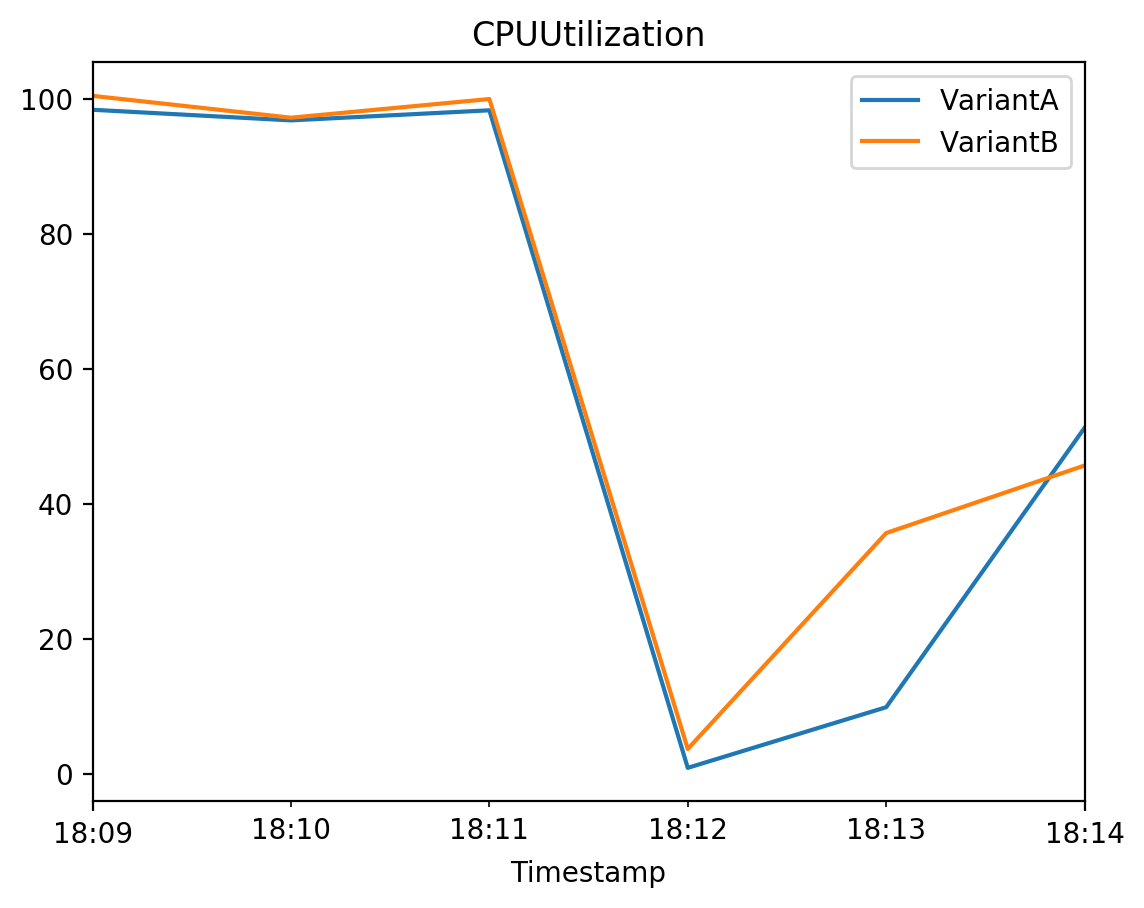

In [19]:
# CPUUtilization
# The sum of each individual CPU core's utilization. 
# The CPU utilization of each core can range between 0 and 100. For example, if there are four CPUs, CPUUtilization can range from 0% to 400%.
plot_endpoint_metrics_for_variants(
    endpoint_name=model_ab_endpoint_name, 
    namespace_name="/aws/sagemaker/Endpoints", 
    metric_name="CPUUtilization",
    variant_names=variant_names,
    start_time=start_time,
    end_time=end_time
)

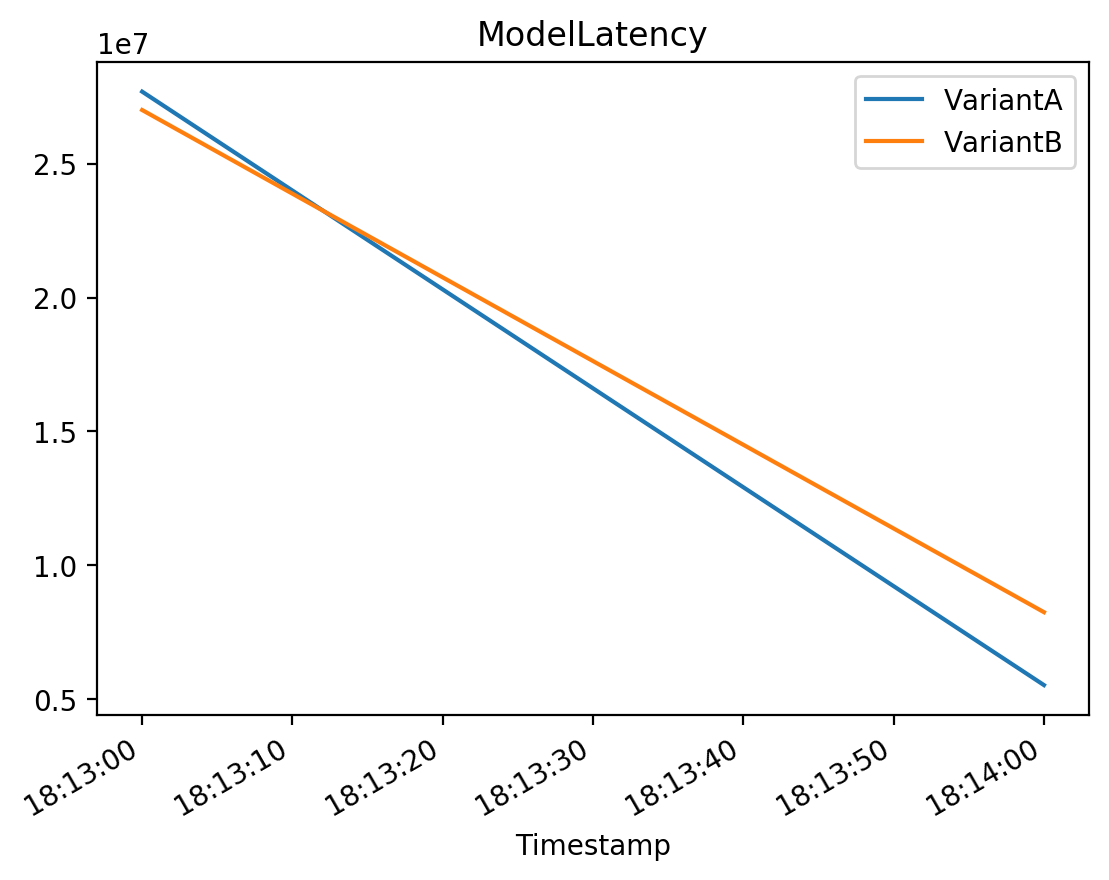

In [20]:
# ModelLatency
# The interval of time taken by a model to respond as viewed from SageMaker (in microseconds).
plot_endpoint_metrics_for_variants(
    endpoint_name=model_ab_endpoint_name, 
    namespace_name="AWS/SageMaker", 
    metric_name="ModelLatency",
    variant_names=variant_names,
    start_time=start_time,
    end_time=end_time
)

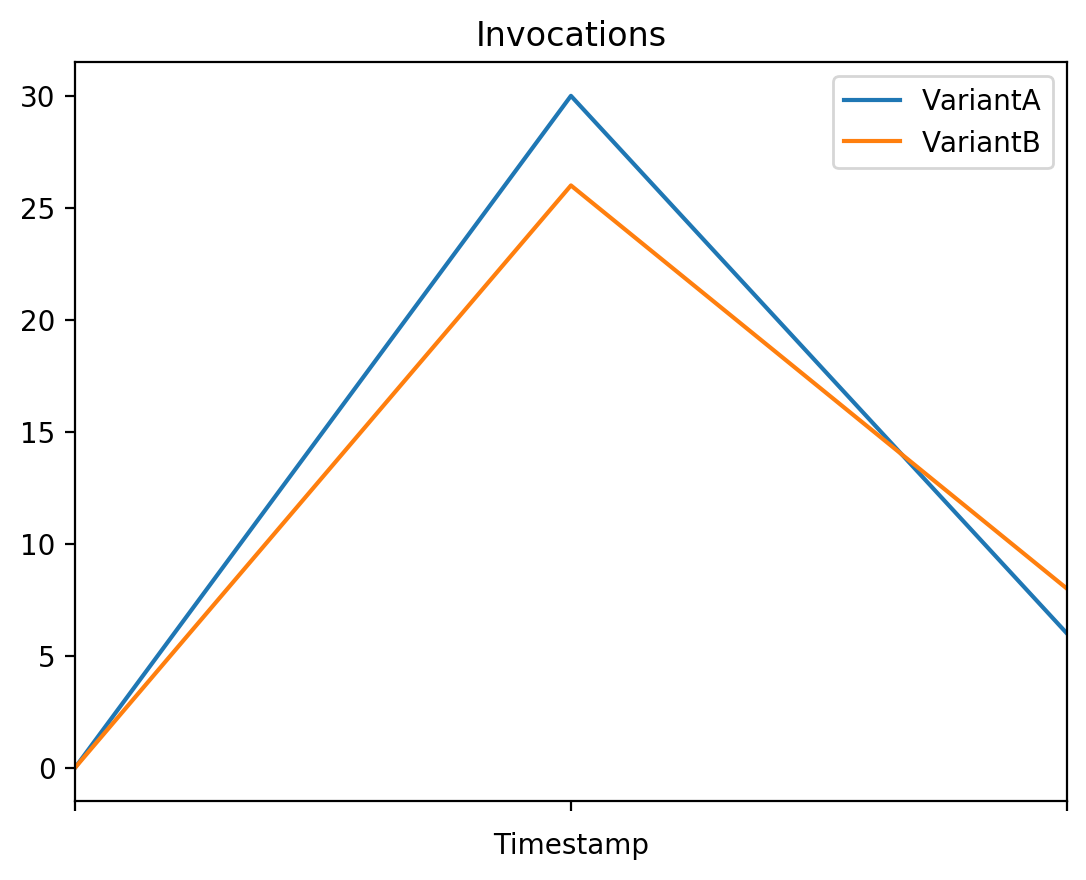

In [21]:
# Invocations
# The number of requests sent to a model endpoint.
plot_endpoint_metrics_for_variants(
    endpoint_name=model_ab_endpoint_name, 
    namespace_name="AWS/SageMaker", 
    metric_name="Invocations",
    variant_names=variant_names,
    start_time=start_time,
    end_time=end_time    
)

### 2.5 Review model requests/responses from data capture S3 location

In [22]:
from IPython.core.display import display, HTML
    
display(HTML('<b>Review <a target="blank" href="https://s3.console.aws.amazon.com/s3/buckets/{}?region={}&prefix=endpoint_data_capture/{}/">S3 Data Capture</a></b>'.format(bucket, region, model_ab_endpoint_name)))

### 2.6 Copy the requests/responses locally to inspect

We will use a super-useful library called `jsonlines` to handle full json documents separated by newlines.  

For more information on `jsonlines`, click [here](https://jsonlines.readthedocs.io/en/latest/).

In [23]:
!aws s3 cp --recursive $data_capture_s3_uri .

download: s3://sagemaker-us-east-1-144249581974/endpoint_data_capture/ab-1667961602/VariantB/2022/11/09/02/54-25-675-8e01da04-153b-4236-8f3a-cbd28dc5a457.jsonl to ab-1667961602/VariantB/2022/11/09/02/54-25-675-8e01da04-153b-4236-8f3a-cbd28dc5a457.jsonl
download: s3://sagemaker-us-east-1-144249581974/endpoint_data_capture/ab-1667961602/VariantB/2022/11/09/02/52-22-437-b3a43e76-069a-437c-96e8-0ccfc8db715a.jsonl to ab-1667961602/VariantB/2022/11/09/02/52-22-437-b3a43e76-069a-437c-96e8-0ccfc8db715a.jsonl
download: s3://sagemaker-us-east-1-144249581974/endpoint_data_capture/ab-1667961602/VariantA/2022/11/09/02/48-44-835-03ca67c3-d0a7-426f-aa75-ed942bee7816.jsonl to ab-1667961602/VariantA/2022/11/09/02/48-44-835-03ca67c3-d0a7-426f-aa75-ed942bee7816.jsonl
download: s3://sagemaker-us-east-1-144249581974/endpoint_data_capture/ab-1667961602/VariantB/2022/11/09/02/48-38-971-387067ab-b1a1-4c88-977b-69cb4a2336d1.jsonl to ab-1667961602/VariantB/2022/11/09/02/48-38-971-387067ab-b1a1-4c88-977b-69cb4a2

In [24]:
import pandas as pd
import jsonlines
from glob import glob
import base64

pd.set_option('max_colwidth', 500)

glob_pattern = 'endpoint_data_capture/*/*/*/*/*/*/*.jsonl'
for json_filename in glob(glob_pattern):
    json_data = jsonlines.open(json_filename) 

    df = pd.json_normalize(json_data)[['captureData.endpointInput.data', 'captureData.endpointOutput.data']]
    df = df.applymap(lambda encoded_data: base64.b64decode(encoded_data).decode())
    df = df.append(df, ignore_index=True)
    
df

,captureData.endpointInput.data,captureData.endpointOutput.data
0,"{""features"": [""I love this product!""]}\n{""features"": [""OK, but not great.""]}\n{""features"": [""This is not the right product.""]}","{""probability"": 0.9605445861816406, ""predicted_label"": 1}\n{""probability"": 0.5798221230506897, ""predicted_label"": 0}\n{""probability"": 0.7667604684829712, ""predicted_label"": -1}"
1,"{""features"": [""I love this product!""]}\n{""features"": [""OK, but not great.""]}\n{""features"": [""This is not the right product.""]}","{""probability"": 0.9605445861816406, ""predicted_label"": 1}\n{""probability"": 0.5798221230506897, ""predicted_label"": 0}\n{""probability"": 0.7667604684829712, ""predicted_label"": -1}"
2,"{""features"": [""I love this product!""]}\n{""features"": [""OK, but not great.""]}\n{""features"": [""This is not the right product.""]}","{""probability"": 0.9605445861816406, ""predicted_label"": 1}\n{""probability"": 0.5798221230506897, ""predicted_label"": 0}\n{""probability"": 0.7667604684829712, ""predicted_label"": -1}"
3,"{""features"": [""I love this product!""]}\n{""features"": [""OK, but not great.""]}\n{""features"": [""This is not the right product.""]}","{""probability"": 0.9605445861816406, ""predicted_label"": 1}\n{""probability"": 0.5798221230506897, ""predicted_label"": 0}\n{""probability"": 0.7667604684829712, ""predicted_label"": -1}"
4,"{""features"": [""I love this product!""]}\n{""features"": [""OK, but not great.""]}\n{""features"": [""This is not the right product.""]}","{""probability"": 0.9605445861816406, ""predicted_label"": 1}\n{""probability"": 0.5798221230506897, ""predicted_label"": 0}\n{""probability"": 0.7667604684829712, ""predicted_label"": -1}"
5,"{""features"": [""I love this product!""]}\n{""features"": [""OK, but not great.""]}\n{""features"": [""This is not the right product.""]}","{""probability"": 0.9605445861816406, ""predicted_label"": 1}\n{""probability"": 0.5798221230506897, ""predicted_label"": 0}\n{""probability"": 0.7667604684829712, ""predicted_label"": -1}"
6,"{""features"": [""I love this product!""]}\n{""features"": [""OK, but not great.""]}\n{""features"": [""This is not the right product.""]}","{""probability"": 0.9605445861816406, ""predicted_label"": 1}\n{""probability"": 0.5798221230506897, ""predicted_label"": 0}\n{""probability"": 0.7667604684829712, ""predicted_label"": -1}"
7,"{""features"": [""I love this product!""]}\n{""features"": [""OK, but not great.""]}\n{""features"": [""This is not the right product.""]}","{""probability"": 0.9605445861816406, ""predicted_label"": 1}\n{""probability"": 0.5798221230506897, ""predicted_label"": 0}\n{""probability"": 0.7667604684829712, ""predicted_label"": -1}"
8,"{""features"": [""I love this product!""]}\n{""features"": [""OK, but not great.""]}\n{""features"": [""This is not the right product.""]}","{""probability"": 0.9605445861816406, ""predicted_label"": 1}\n{""probability"": 0.5798221230506897, ""predicted_label"": 0}\n{""probability"": 0.7667604684829712, ""predicted_label"": -1}"
9,"{""features"": [""I love this product!""]}\n{""features"": [""OK, but not great.""]}\n{""features"": [""This is not the right product.""]}","{""probability"": 0.9605445861816406, ""predicted_label"": 1}\n{""probability"": 0.5798221230506897, ""predicted_label"": 0}\n{""probability"": 0.7667604684829712, ""predicted_label"": -1}"


# 3. Prepare to shift all traffic to variant B

Let's assume that model variant B is the better variant based on some business metrics like more conversions, less churn, etc.  

In this case, we want to shift all traffic to variant B **without downtime**, so we set the `DesiredWeight` for variant A to 0% and variant B to 100%.

In [25]:
updated_endpoint_config = [
    {
        "VariantName": variantA["VariantName"],
        "DesiredWeight": 0,
    },
    {
        "VariantName": variantB["VariantName"],
        "DesiredWeight": 100,
    },
]

### 3.1 Update the endpoint with the new variant weights.

In [26]:
sm.update_endpoint_weights_and_capacities(
    EndpointName=model_ab_endpoint_name, 
    DesiredWeightsAndCapacities=updated_endpoint_config 
)

{'EndpointArn': 'arn:aws:sagemaker:us-east-1:144249581974:endpoint/ab-1668103408',
 'ResponseMetadata': {'RequestId': 'adb194c1-2c58-4d91-8c08-34028ee51c86',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': 'adb194c1-2c58-4d91-8c08-34028ee51c86',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '81',
   'date': 'Thu, 10 Nov 2022 18:15:17 GMT'},
  'RetryAttempts': 0}}

### _Wait for the ^^ endpoint update ^^ to complete above (few minutes, please be patient.)_

### 3.2 Review the endpoint status in the AWS console.

1. open the link below
2. notice that you are in the section Amazon SageMaker -> Endpoints
3. check the name of the endpoint, its ARN and status (`Updating` or `InService`)
4. below you can see the endpoint runtime settings with the updated weights

In [27]:
from IPython.core.display import display, HTML

display(HTML('<b>Review <a target="blank" href="https://console.aws.amazon.com/sagemaker/home?region={}#/endpoints/{}">SageMaker REST endpoint</a></b>'.format(region, model_ab_endpoint_name)))

In [28]:
waiter = sm.get_waiter("endpoint_in_service")
waiter.wait(EndpointName=model_ab_endpoint_name)

### 3.3 Run some more predictions and view the metrics for each variant.

In [29]:
%%time

for i in range(0, 100):
    predicted_classes = predictor.predict(inputs)

CPU times: user 251 ms, sys: 1.39 ms, total: 253 ms
Wall time: 1min 48s


### _Μake sure the predictions ^^ above ^^ ran successfully (1-2 minutes, please be patient.)_

If you see `Metrics not yet available`, please be patient as metrics may take a few minutes to appear in CloudWatch. Compare the results with the plots above.

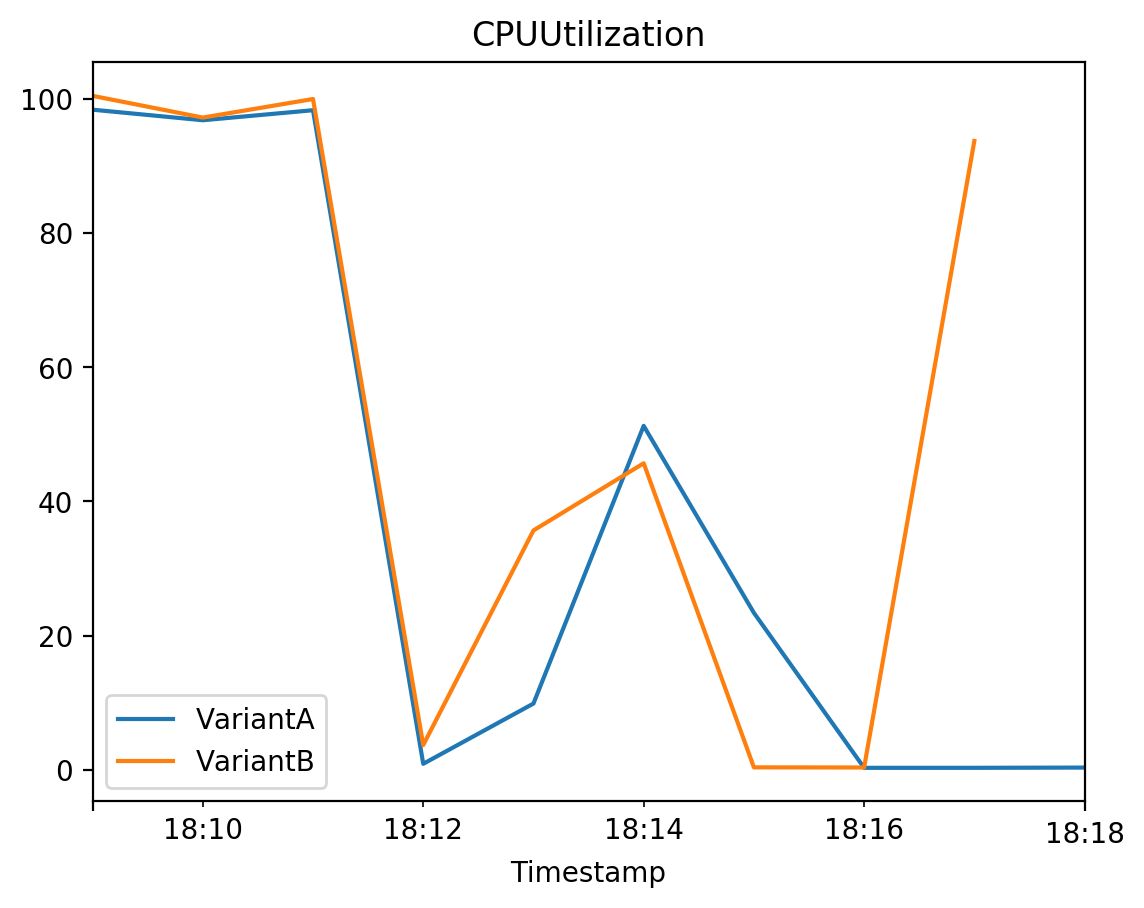

In [30]:
# CPUUtilization

# The sum of each individual CPU core's utilization. 
# The CPU utilization of each core can range between 0 and 100. For example, if there are four CPUs, CPUUtilization can range from 0% to 400%.
plot_endpoint_metrics_for_variants(
    endpoint_name=model_ab_endpoint_name, 
    namespace_name="/aws/sagemaker/Endpoints",
    metric_name="CPUUtilization",
    variant_names=variant_names,
    start_time=start_time,
    end_time=end_time
)

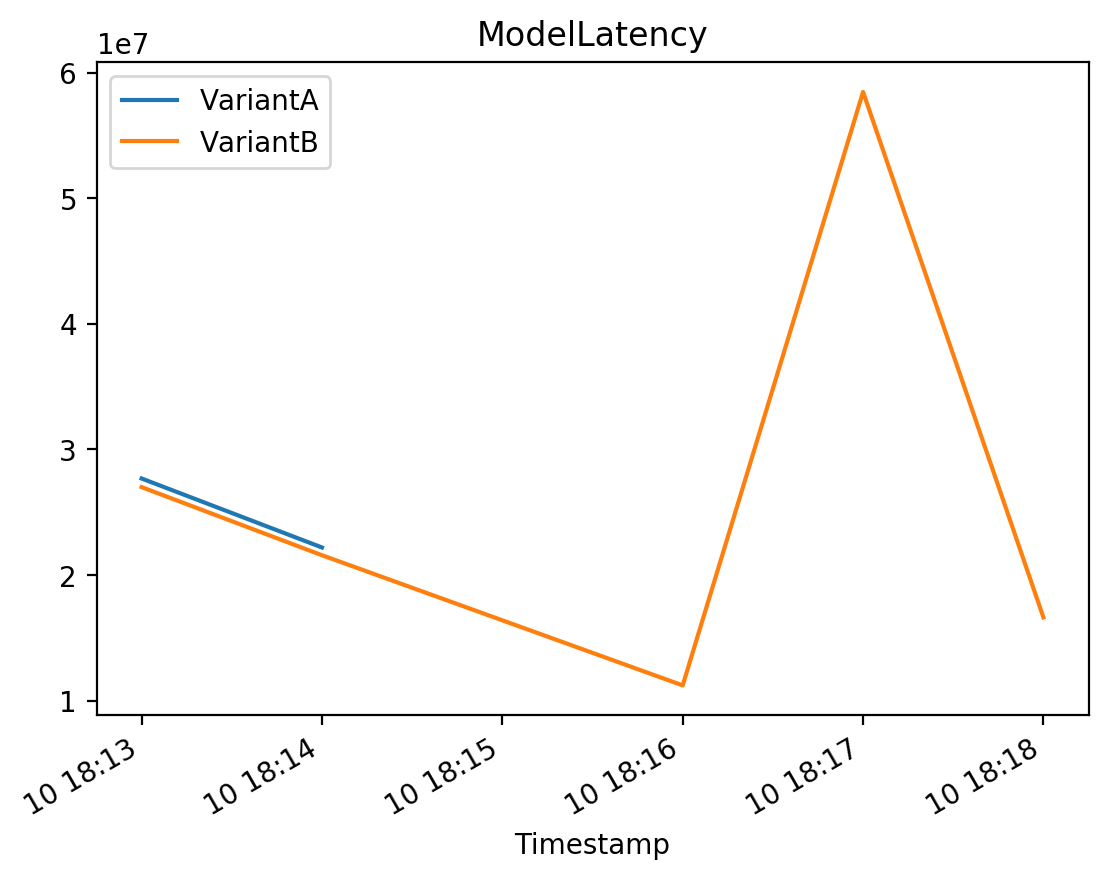

In [31]:
# ModelLatency

# The interval of time taken by a model to respond as viewed from SageMaker (in microseconds).
plot_endpoint_metrics_for_variants(
    endpoint_name=model_ab_endpoint_name, 
    namespace_name="AWS/SageMaker", 
    metric_name="ModelLatency",
    variant_names=variant_names,
    start_time=start_time,
    end_time=end_time    
)

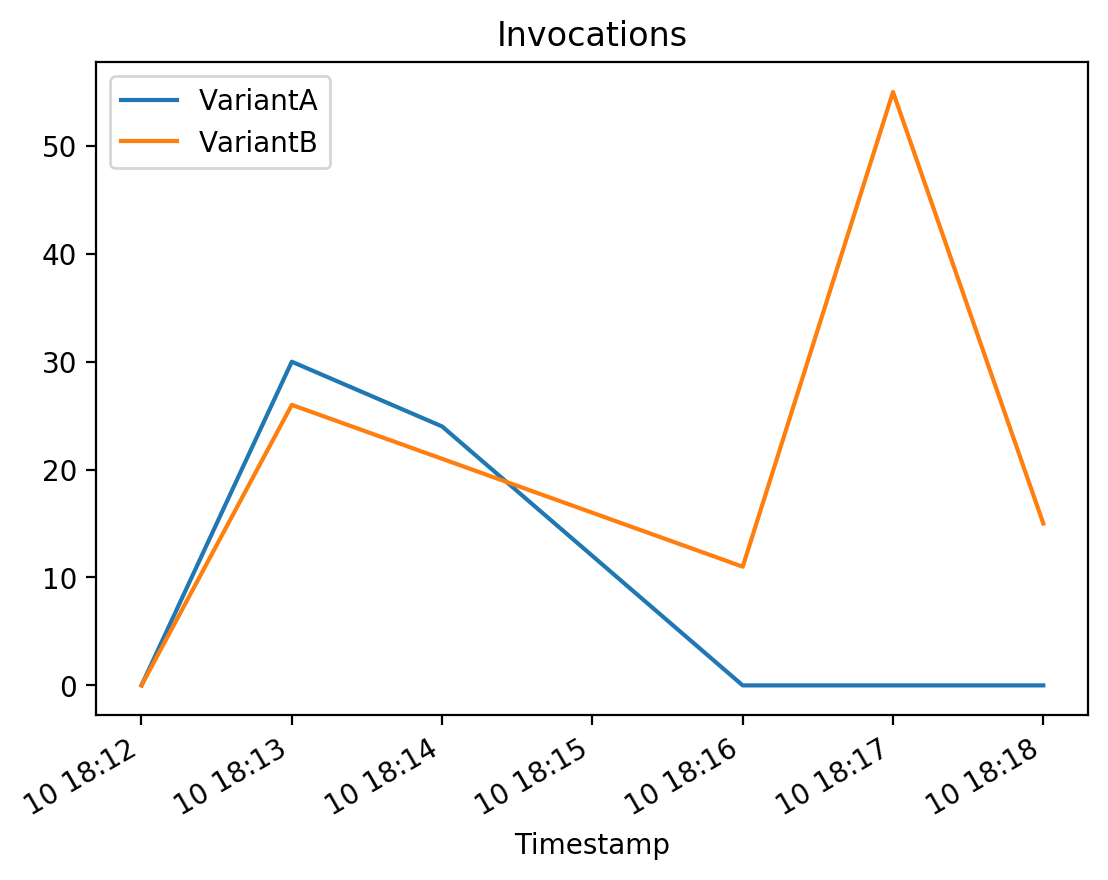

In [32]:
# Invocations

# The number of requests sent to a model endpoint.
plot_endpoint_metrics_for_variants(
    endpoint_name=model_ab_endpoint_name, 
    namespace_name="AWS/SageMaker", 
    metric_name="Invocations",
    variant_names=variant_names,
    start_time=start_time,
    end_time=end_time    
)

# 4. Autoscale to handle more model-prediction traffic

### 4.1 Configure autoscaling for variant B
For variant B, we specify the `MinCapacity` indicates the minimum number of instances and  `MaxCapacity` is the maximum number of instances for your endpoint. 

In this case, we always have at least 1 instance running and a maximum of 2 during peak periods. 

In [33]:
autoscale.register_scalable_target(
    ServiceNamespace="sagemaker",
    ResourceId="endpoint/" + model_ab_endpoint_name + "/variant/VariantB",
    ScalableDimension="sagemaker:variant:DesiredInstanceCount",
    MinCapacity=1,
    MaxCapacity=2,
    RoleARN=role,
    SuspendedState={
        "DynamicScalingInSuspended": False,
        "DynamicScalingOutSuspended": False,
        "ScheduledScalingSuspended": False,
    },
)

{'ResponseMetadata': {'RequestId': '37d14942-6e2d-425f-b155-b99f3f5db739',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '37d14942-6e2d-425f-b155-b99f3f5db739',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '2',
   'date': 'Thu, 10 Nov 2022 18:18:39 GMT'},
  'RetryAttempts': 0}}

In [34]:
waiter = sm.get_waiter("endpoint_in_service")
waiter.wait(EndpointName=model_ab_endpoint_name)

### 4.2 Define and apply a scaling policy

`TargetTrackingScaling` is the scaling policy uses a scaling metric and a target value as the indicator to scale. 

`PredefinedMetricSpecification` is the number of invocations on your instance.

`TargetValue` is the number of invocations per ML instance you want to allow before triggering your scaling policy.

In [35]:
autoscale.put_scaling_policy(
    PolicyName="bert-reviews-autoscale-policy",
    ServiceNamespace="sagemaker",
    ResourceId="endpoint/" + model_ab_endpoint_name + "/variant/VariantB",
    ScalableDimension="sagemaker:variant:DesiredInstanceCount",
    PolicyType="TargetTrackingScaling",
    TargetTrackingScalingPolicyConfiguration={
        "TargetValue": 2.0, # the number of invocations per ML instance you want to allow before triggering your scaling policy
        "PredefinedMetricSpecification": {
            "PredefinedMetricType": "SageMakerVariantInvocationsPerInstance", # scaling metric
        },
        "ScaleOutCooldown": 60, # wait time, in seconds, before beginning another scale out activity after last one completes
        "ScaleInCooldown": 300, # wait time, in seconds, before beginning another scale in activity after last one completes
    },
)

{'PolicyARN': 'arn:aws:autoscaling:us-east-1:144249581974:scalingPolicy:99da69b7-13d0-4a41-95be-6b7477bf9707:resource/sagemaker/endpoint/ab-1668103408/variant/VariantB:policyName/bert-reviews-autoscale-policy',
 'Alarms': [{'AlarmName': 'TargetTracking-endpoint/ab-1668103408/variant/VariantB-AlarmHigh-baf71ff5-8295-4849-a237-7de0f9a82b93',
   'AlarmARN': 'arn:aws:cloudwatch:us-east-1:144249581974:alarm:TargetTracking-endpoint/ab-1668103408/variant/VariantB-AlarmHigh-baf71ff5-8295-4849-a237-7de0f9a82b93'},
  {'AlarmName': 'TargetTracking-endpoint/ab-1668103408/variant/VariantB-AlarmLow-782260d4-505d-482e-b2c1-4c7e3161da35',
   'AlarmARN': 'arn:aws:cloudwatch:us-east-1:144249581974:alarm:TargetTracking-endpoint/ab-1668103408/variant/VariantB-AlarmLow-782260d4-505d-482e-b2c1-4c7e3161da35'}],
 'ResponseMetadata': {'RequestId': '94f51355-587c-4ff2-88be-6672616a2fe9',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '94f51355-587c-4ff2-88be-6672616a2fe9',
   'content-type': 'ap

In [36]:
waiter = sm.get_waiter("endpoint_in_service")
waiter.wait(EndpointName=model_ab_endpoint_name)

### 4.3 Generate more traffic (1-2 minutes, please be patient).

In [37]:
%%time

for i in range(0, 100):
    predicted_classes = predictor.predict(inputs)

CPU times: user 231 ms, sys: 6.98 ms, total: 238 ms
Wall time: 1min 47s


### 4.4 Review the autoscaling in action

1. open the link
2. notice that you are in the section Amazon SageMaker -> Endpoints
3. below you can see the endpoint runtime settings with the instance counts.

You can run the predictions multiple times to observe the increase of the instance count to 2.

In [38]:
from IPython.core.display import display, HTML

display(HTML('<b>Review <a target="blank" href="https://console.aws.amazon.com/sagemaker/home?region={}#/endpoints/{}">SageMaker REST endpoint</a></b>'.format(region, model_ab_endpoint_name)))
